# **Imports**

In [44]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


# **Parameters**

In [45]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10
CHANNELS = 3
TRAIN_DIR = '/kaggle/input/leaf-diseases-extended/dataset/train'
TEST_DIR = '/kaggle/input/leaf-diseases-extended/dataset/test'
MODEL_SAVE_PATH = '/kaggle/working/trained_model.keras'
HISTORY_SAVE_PATH = '/kaggle/working/training_history.pkl'

# **Loading datasets**

## **Loading test dataset**

In [46]:
# Loading datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='training'
)

Found 96509 files belonging to 67 classes.
Using 86859 files for training.


## **Load validation dataset**

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)

Found 96509 files belonging to 67 classes.
Using 9650 files for validation.


## **Load test dataset**

In [48]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16573 files belonging to 67 classes.


# **Display class names**

In [49]:
# Display class names
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cassava__bacterial_blight', 'Cassava__brown_streak_disease', 'Cassava__green_mottle', 'Cassava__healthy', 'Cassava__mosaic_disease', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Cherry__powdery_mildew', 'Coffee__healthy', 'Coffee__rust', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Cucumber__diseased', 'Cucumber__healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Mango_Anthracnose', 'Mango_Bacterial_Canker', 'Mango_Cutting_Weevil', 'Mango_Die_Back', 'Mango_Gall_Midge', 'Mango_Healthy', 'Mango_Powdery_Mildew', 'Mango_Sooty_Mould', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Peppe

# **Inspect first batch from training dataset**

In [50]:
# Inspect first batch from training dataset
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].numpy())

(32, 256, 256, 3)
[16 13 50 48 57 53 45 33 46 37  4 34 33 28 27  0 56 38 45 10 45 10 41 26
 15 23 36 64 44 50 17 62]
[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 1.  0.  0.]
  [ 3.  0.  4.]
  [14.  7. 15.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [14. 12. 13.]
  [ 3.  0.  4.]
  [ 4.  0.  5.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 1.  0.  0.]
  [ 3.  0.  4.]
  [24. 19. 26.]]

 ...

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 0.  0.  2.]
  [ 0.  0.  2.]
  [ 0.  0.  2.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 0.  1.  2.]
  [ 0.  0.  2.]
  [ 0.  0.  2.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 0.  1.  2.]
  [ 0.  0.  2.]
  [ 0.  0.  2.]]]


# **Function to display random images from each class**

In [51]:
# Function to display random images from each class
def display_random_images_from_class(class_dir, class_name, num_images=3, image_size=(256, 256)):
    all_images = os.listdir(class_dir)
    selected_images = random.sample(all_images, num_images)
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(class_dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array.astype("uint8"))
        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

class_dirs = [os.path.join(TRAIN_DIR, class_name) for class_name in sorted(os.listdir(TRAIN_DIR)) if os.path.isdir(os.path.join(TRAIN_DIR, class_name))]
show_images = input("Do you want to display the images? (yes/no): ").strip().lower()

if show_images == 'yes':
    for class_dir in class_dirs:
        class_name = os.path.basename(class_dir)
        display_random_images_from_class(class_dir, class_name, 3, (256, 256))
else:
    print("Images will not be displayed.")

Do you want to display the images? (yes/no):  no


Images will not be displayed.


# **Data augmentation and preprocessing**

## **Preprocessing**

In [52]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

## **Data augmentation**

In [53]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# **Input shape**

In [54]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

# **Define the model using functional API**

In [55]:
# Define the model using functional API
input_layer = layers.Input(shape=input_shape)
x = resize_and_rescale(input_layer)
x = data_augmentation(x)
base_model = DenseNet201(input_shape=input_shape, weights='imagenet', include_top=False)(x)
x = layers.GlobalAveragePooling2D()(base_model)
output_layer = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 8, 8, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 67)             │       128,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,450,691 (70.38 MB)

 Trainable params: 18,221,635 (69.51 MB)

 Non-trainable params: 229,056 (894.75 KB)

# **Compile the model**

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy']
)

# **Learning rate scheduler**

In [57]:
# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# **Define custom callback**

In [58]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{EPOCHS}")
        print(f"Train Loss: {logs['loss']:.4f}, Train Accuracy: {logs['sparse_categorical_accuracy']:.4f}")
        print(f"Validation Loss: {logs['val_loss']:.4f}, Validation Accuracy: {logs['val_sparse_categorical_accuracy']:.4f}")

custom_callback = CustomCallback()

# **Save model callback**

In [59]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# **Train or load the model**

In [62]:
# Parameters
MODEL_SAVE_PATH = '/kaggle/working/trained_model.keras'
HISTORY_SAVE_PATH = '/kaggle/working/training_history.pkl'
EPOCHS = 10

# Ensure the directory for saving the model exists
model_dir = os.path.dirname(MODEL_SAVE_PATH)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Train or load the model
if os.path.exists(MODEL_SAVE_PATH):
    print("Loading pre-trained model...")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    model.summary()
else:
    print("Training the model...")
    # Assuming train_ds and val_ds are defined
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[custom_callback, model_checkpoint_callback, lr_scheduler],
        verbose=1
    )
    # Save the history
    with open(HISTORY_SAVE_PATH, 'wb') as f:
        pickle.dump(history.history, f)
    
    # Save the model
    model.save(MODEL_SAVE_PATH)

Training the model...
Epoch 1/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - loss: 0.3483 - sparse_categorical_accuracy: 0.8813Epoch 1/10
Train Loss: 0.2929, Train Accuracy: 0.8979
Validation Loss: 0.5276, Validation Accuracy: 0.8363
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 2156s 794ms/step - loss: 0.3482 - sparse_categorical_accuracy: 0.8813 - val_loss: 0.5276 - val_sparse_categorical_accuracy: 0.8363 - learning_rate: 0.0010
Epoch 2/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9227Epoch 2/10
Train Loss: 0.2064, Train Accuracy: 0.9245
Validation Loss: 0.3964, Validation Accuracy: 0.8694
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 2144s 790ms/step - loss: 0.2141 - sparse_categorical_accuracy: 0.9227 - val_loss: 0.3964 - val_sparse_categorical_accuracy: 0.8694 - learning_rate: 0.0010
Epoch 3/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - loss: 0.1772 - sparse_categorical_accuracy: 0.9343Epoch 3/10
Train Loss: 0.1733, Train Accuracy: 0.9355
Validation Los

# **Evaluate overall accuracy**

In [63]:
loss, accuracy = model.evaluate(test_ds)
print(f"Overall Test Accuracy: {accuracy * 100:.2f}%")

189/518 ━━━━━━━━━━━━━━━━━━━━ 52s 160ms/step - loss: 0.0939 - sparse_categorical_accuracy: 0.9723

Invalid SOS parameters for sequential JPEG


207/518 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - loss: 0.0939 - sparse_categorical_accuracy: 0.9722

Invalid SOS parameters for sequential JPEG


256/518 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9720

Invalid SOS parameters for sequential JPEG


352/518 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - loss: 0.0949 - sparse_categorical_accuracy: 0.9716

Invalid SOS parameters for sequential JPEG


374/518 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9715

Invalid SOS parameters for sequential JPEG


509/518 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9712

Invalid SOS parameters for sequential JPEG


518/518 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9712
Overall Test Accuracy: 97.03%


# **Model History**

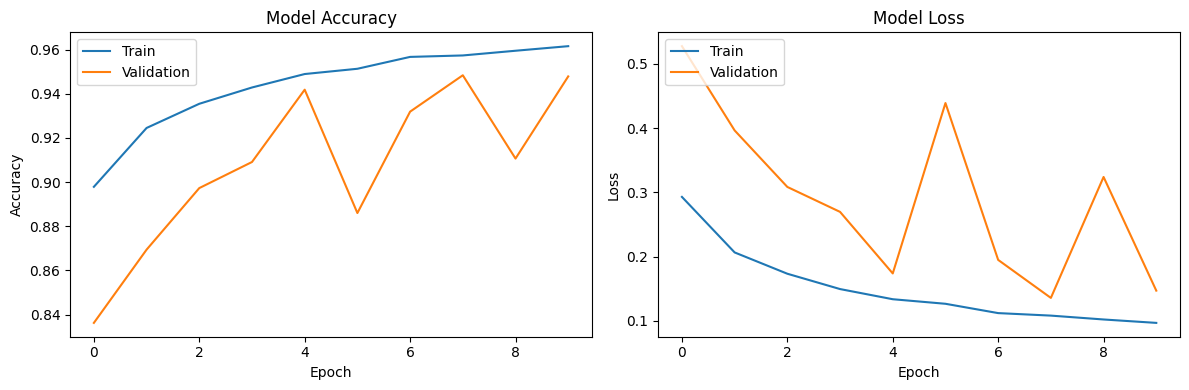

In [64]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# **Get the class names**

In [66]:
class_names = test_ds.class_names

# **Initialize a dictionary to store accuracy for each class**

In [67]:
class_accuracies = {class_name: [] for class_name in class_names}

# **Iterate over the test dataset to calculate accuracy for each class**

In [68]:
# Iterate over the test dataset to calculate accuracy for each class
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    for label, predicted_label in zip(labels.numpy(), predicted_labels):
        class_name = class_names[label]
        is_correct = int(label == predicted_label)
        class_accuracies[class_name].append(is_correct)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Invalid SOS parameters for sequential JPEG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Invalid SOS parameters for sequential JPEG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

Invalid SOS parameters for sequential JPEG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10

Invalid SOS parameters for sequential JPEG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Invalid SOS parameters for sequential JPEG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/s

Invalid SOS parameters for sequential JPEG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


# **Calculate and print accuracy for each class**

In [69]:
# Calculate and print accuracy for each class
for class_name in class_accuracies:
    accuracy = np.mean(class_accuracies[class_name]) * 100
    print(f"{class_name} with an accuracy of {accuracy:.2f}%")

Apple___Apple_scab with an accuracy of 100.00%
Apple___Black_rot with an accuracy of 99.80%
Apple___Cedar_apple_rust with an accuracy of 98.86%
Apple___healthy with an accuracy of 97.61%
Blueberry___healthy with an accuracy of 99.34%
Cassava__bacterial_blight with an accuracy of 45.95%
Cassava__brown_streak_disease with an accuracy of 54.05%
Cassava__green_mottle with an accuracy of 41.30%
Cassava__healthy with an accuracy of 92.19%
Cassava__mosaic_disease with an accuracy of 84.78%
Cherry_(including_sour)___Powdery_mildew with an accuracy of 97.15%
Cherry_(including_sour)___healthy with an accuracy of 100.00%
Cherry__powdery_mildew with an accuracy of 0.00%
Coffee__healthy with an accuracy of 95.89%
Coffee__rust with an accuracy of 86.00%
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot with an accuracy of 95.85%
Corn_(maize)___Common_rust_ with an accuracy of 100.00%
Corn_(maize)___Northern_Leaf_Blight with an accuracy of 92.03%
Corn_(maize)___healthy with an accuracy of 99.78%
Cuc

# **Function to predict class and confidence**

In [83]:
# Function to predict class and confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Function to display 3 random images from each class
def plot_images_from_classes(test_dir, model, class_names, num_images=3, image_size=(256, 256)):
    class_dirs = [os.path.join(test_dir, class_name) for class_name in class_names]
    plt.figure(figsize=(15, 5 * len(class_names)))
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = class_dirs[class_idx]
        all_images = os.listdir(class_dir)
        selected_images = random.sample(all_images, min(num_images, len(all_images)))
        
        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            predicted_class, confidence = predict(model, img)
            
            ax = plt.subplot(len(class_names), num_images, class_idx * num_images + i + 1)
            plt.imshow(img_array.astype("uint8"))
            plt.title(f"Actual: {class_name}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
            plt.axis("off")
    
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

# Specify the correct path to the test directory
TEST_DIR = '/kaggle/input/leaf-diseases-extended/dataset/test'
class_names = sorted(os.listdir(TEST_DIR))

show_images = input("Do you want to display the images? (yes/no): ").strip().lower()

if show_images == 'yes':
    plot_images_from_classes(TEST_DIR, model, class_names)
else:
    print("Images will not be displayed.")

Do you want to display the images? (yes/no):  no


Images will not be displayed.


# **Load your trained model**

In [71]:
# Assuming class names are directories in your training dataset
class_names = sorted(os.listdir(TRAIN_DIR))

# Load the trained model
model = load_model(MODEL_SAVE_PATH)

# Load the training history
with open(HISTORY_SAVE_PATH, 'rb') as f:
    history = pickle.load(f)

# **Function to predict class and confidence on real time**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted class: Apple___Black_rot with 100.0% confidence.


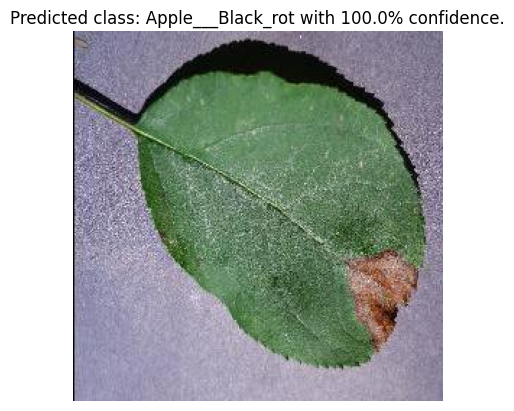

In [85]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

image_path = '/kaggle/input/leaf-diseases-extended/dataset/test/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734_270deg.JPG'
img = image.load_img(image_path, target_size=(256, 256))
predicted_class, confidence = predict(model, img)

print(f"Predicted class: {predicted_class} with {confidence}% confidence.")

# Display the predicted image
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class} with {confidence}% confidence.")
plt.axis("off")
plt.show()

# **Users choice**

Enter the directory name (e.g., 'potato_late_blight'):  Strawberry___Leaf_scorch


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


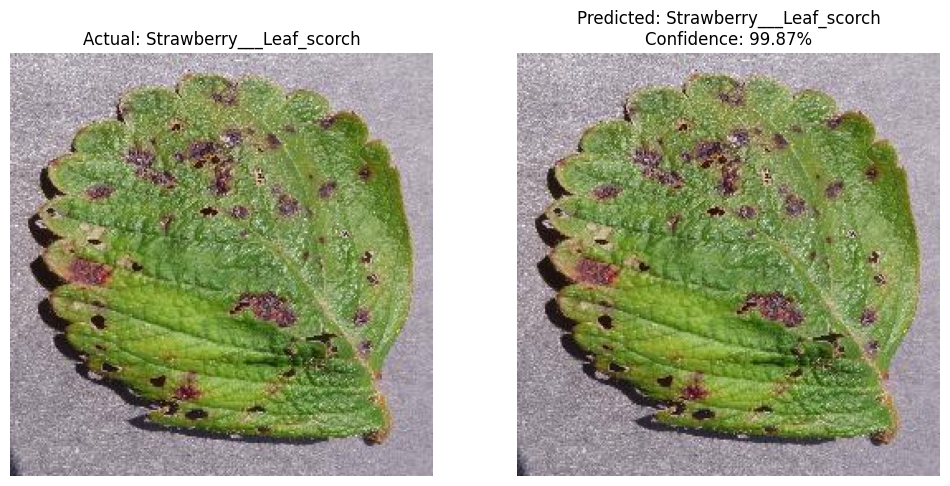

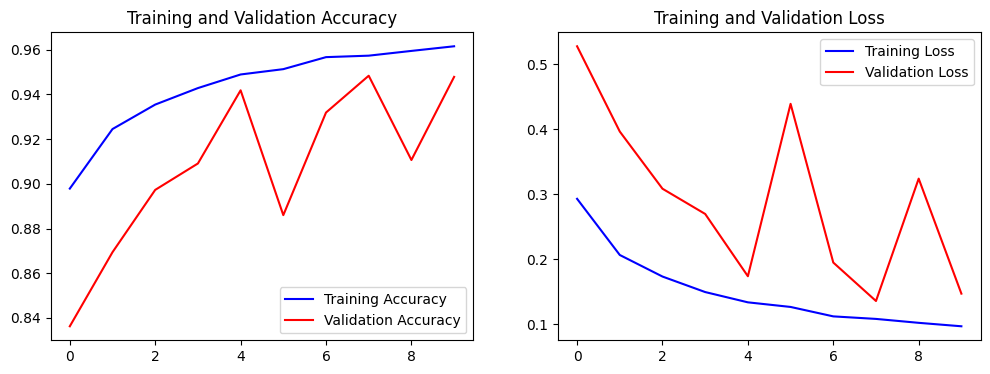

In [73]:
# Predict function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Plot image and metrics
def plot_image_and_metrics(class_dir, model, class_names, history, image_size=(256, 256)):
    all_images = os.listdir(class_dir)
    if not all_images:
        print("No images found in the specified directory.")
        return
    
    img_name = random.choice(all_images)
    img_path = os.path.join(class_dir, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    actual_class = os.path.basename(class_dir)
    predicted_class, confidence = predict(model, img)
    
    # Display the image with actual and predicted labels
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_array.astype("uint8"))
    plt.title(f"Actual: {actual_class}", fontsize=12)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_array.astype("uint8"))
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence}%", fontsize=12)
    plt.axis("off")
    
    plt.show()

    # Plot accuracy and loss if available
    if history:
        if 'sparse_categorical_accuracy' in history and 'val_sparse_categorical_accuracy' in history:
            acc = history['sparse_categorical_accuracy']
            val_acc = history['val_sparse_categorical_accuracy']
            loss = history['loss']
            val_loss = history['val_loss']

            epochs = range(len(acc))

            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            plt.plot(epochs, acc, 'b', label='Training Accuracy')
            plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(epochs, loss, 'b', label='Training Loss')
            plt.plot(epochs, val_loss, 'r', label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.legend()

            plt.show()
        else:
            print("No accuracy and loss data available in the model history.")
    else:
        print("No training history available to plot accuracy and loss.")

# Prompt user for input
user_input = input("Enter the directory name (e.g., 'potato_late_blight'): ")

# Assuming TEST_DIR is the directory containing all class directories
class_dir = os.path.join(TEST_DIR, user_input)

if os.path.isdir(class_dir):
    plot_image_and_metrics(class_dir, model, class_names, history)
else:
    print(f"Directory '{user_input}' not found.")